In [1]:
import os
import random
import time
import imp

import numpy as np
import pandas as pd
import xarray as xr

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE


import keras
import keras.backend
import keras.models
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import innvestigate
import innvestigate.utils as iutils

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absolute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

Using TensorFlow backend.
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/q3/opt/anaconda3/en

In [2]:
# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "/Users/MyFolders/Aarhus/innvestigate/examples/utils.py")
mnistutils = imp.load_source("utils_mnist", "/Users/MyFolders/Aarhus/innvestigate/examples/utils_mnist.py")

time: 110 ms


In [3]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 513 ms


In [4]:
ds.close()

time: 214 ms


In [5]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns= ['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 17.2 s


In [6]:
df.head()

,date,field_id,polarization,afgkode,afgroede,imk_areal,satellite,stats_max,stats_mean,stats_median,stats_min,stats_std
0,2018-07-08,61853445,VH,151,"Kartofler, stivelses-",1.83,S1B,-17.0,-23.705883,-23.0,-31.0,3.019831
1,2018-07-08,61853445,VV,151,"Kartofler, stivelses-",1.83,S1B,-9.0,-12.705882,-12.0,-18.0,1.898597
2,2018-07-08,61853445,VV-VH,151,"Kartofler, stivelses-",1.83,S1B,17.0,10.470589,10.0,4.0,3.046071
3,2018-07-08,61952339,VH,151,"Kartofler, stivelses-",6.02,S1B,-15.0,-20.635212,-20.0,-30.0,2.294672
4,2018-07-08,61952339,VV,151,"Kartofler, stivelses-",6.02,S1B,-10.0,-14.428169,-15.0,-21.0,2.151264


time: 180 ms


In [7]:
class_names = []

time: 118 ms


In [8]:
def prepare_data(satellite_type):
    """This function prepares the dataset which can be then be used to train machine learning classifiers
    Args: 
        satellite_type: Specify S1A, S1B or all (for both satellites)
    Returns: 
        df_sklearn: dataframe with crop names in Danish
        df_sklearn_remapped: dataframe with crop names in English. Also has Label ID for each crop.
        class_names: names of crop types in the dataset in English
        X_train: training dataset
        y_train: training labels
        X_test: testting dataset
        y_test: testing labels
    """

    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-01-01', '2019-12-31'), 
                                fields='all', 
                                satellite=satellite_type, 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'Label ID'
    
    mapping = {
    0: 'Potato',
    1: 'Spring barley',
    2: 'Winter barley',
    3: 'Spring wheat',
    4: 'Winter wheat',
    5: 'Winter rye',
    6: 'Spring oat',
    7: 'Maize',
    8: 'Rapeseed',
    9: 'Permanent grass',
    10: 'Willow',
    11: 'Forest'
    }

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit to training data and then scale training data
    X_test = scaler.transform(X_test) 
    
    return df_sklearn, df_sklearn_remapped, class_names, X_train, y_train, X_test, y_test

time: 86.7 ms


In [9]:
df_sklearn, df_sklearn_remapped, class_names, X_train, y_train, X_test, y_test = prepare_data("S1A")

time: 31 s


In [10]:
class_names

['Potato',
 'Spring barley',
 'Winter barley',
 'Spring wheat',
 'Winter wheat',
 'Winter rye',
 'Spring oat',
 'Maize',
 'Rapeseed',
 'Permanent grass',
 'Willow',
 'Forest']

time: 103 ms


In [11]:
feature_names = df_sklearn_remapped.columns[5:]

time: 98.5 ms


In [12]:
num_classes = 12
feature_vector_length = X_train.shape[1]
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

time: 105 ms


In [13]:
# Build MLP in this cell

# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(30, input_shape=input_shape, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Feature shape: (114,)
time: 166 ms


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                3450      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                372       
Total params: 4,752
Trainable params: 4,752
Non-trainable params: 0
_________________________________________________________________
time: 85.5 ms


In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=20)

Epoch 1/20
31051/31051 [==============================] - 2s 58us/step - loss: 0.5749 - acc: 0.8393
Epoch 2/20
31051/31051 [==============================] - 1s 48us/step - loss: 0.3307 - acc: 0.9120
Epoch 3/20
31051/31051 [==============================] - 1s 48us/step - loss: 0.2997 - acc: 0.9217
Epoch 4/20
31051/31051 [==============================] - 2s 49us/step - loss: 0.2820 - acc: 0.9265
Epoch 5/20
31051/31051 [==============================] - 2s 49us/step - loss: 0.2708 - acc: 0.9294
Epoch 6/20
31051/31051 [==============================] - 2s 50us/step - loss: 0.2626 - acc: 0.9316
Epoch 7/20
31051/31051 [==============================] - 2s 52us/step - loss: 0.2560 - acc: 0.9324
Epoch 8/20
31051/31051 [==============================] - 2s 54us/step - loss: 0.2502 - acc: 0.9343
Epoch 9/20
31051/31051 [==============================] - 2s 49us/step - loss: 0.2459 - acc: 0.9358
Epoch 10/20
31051/31051 [==============================] - 2s 49us/step - loss: 0.2423 - acc: 0.9365

time: 33.1 s


In [16]:
# Run the model on the train set
train_results = model.evaluate(X_train, y_train_encoded, verbose=1)
print(f'Train results - Loss: {train_results[0]} - Accuracy: {train_results[1]}%')

31051/31051 [==============================] - 1s 23us/step 
Train results - Loss: 0.1995063910393307 - Accuracy: 0.9465395639431903%
time: 808 ms


In [17]:
# Run the model on the test set

test_results = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

13308/13308 [==============================] - 0s 21us/step
Test results - Loss: 0.31323432123446954 - Accuracy: 0.9232792305380222%
time: 369 ms


In [31]:
# The relevance array will finally store relevance values for each feature
relevance_array = np.empty((0, X_test.shape[1]), int)

# Remove softmax layer from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Build LRP analyzer
analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm)

for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,X_test.shape[1]))
    relevance_array = np.append(relevance_array, analysis, axis=0)
    
relevance_array.shape

(13308, 114)

time: 51 s


In [32]:
mapping = {
0: 'Potato',
1: 'Spring barley',
2: 'Winter barley',
3: 'Spring wheat',
4: 'Winter wheat',
5: 'Winter rye',
6: 'Spring oat',
7: 'Maize',
8: 'Rapeseed',
9: 'Permanent grass',
10: 'Willow',
11: 'Forest'
}

crop_tonumber = {
    'Potato': 0,
    'Spring barley': 1,
    'Winter barley': 2,
    'Spring wheat': 3,
    'Winter wheat': 4,
    'Winter rye': 5,
    'Spring oat': 6,
    'Maize': 7,
    'Rapeseed': 8,
    'Permanent grass': 9,
    'Willow': 10,
    'Forest': 11
}

time: 107 ms


In [65]:
def convert_df(df_explanation):
    """ Extracts polarization of input from feature column and adds it as another column to the dataframe, making
    it easier to plot
    Args: 
        df_explanation: shape -> (X_test.shape[1], 2)
    Return:
        df_explanation: shape -> (X_test.shape[1],3)
    """
    df_explanation['polarization'] = ''
    features = df_explanation['feature'].unique()
    features = features[:-1]  # The last features are the bias values
    df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

    df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
    for feature in features:
        if feature[-5:] == 'VV-VH':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
            df_explanation = df_explanation.replace(feature, feature[:-6])
        elif feature[-2:] == 'VV':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
            df_explanation = df_explanation.replace(feature, feature[:-3])
        else:
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
            df_explanation = df_explanation.replace(feature, feature[:-3])

    df_explanation.sort_values(by=['feature','polarization'])
    return df_explanation

time: 81.1 ms


In [79]:
def mlp_explanation(croptype):
    """Plots the relevance values for each polarization as an aggreagted daily time series line plot 
    for the given crop type.
    
    Args:
        croptype: Specify the crop type
    """
    df_explanation = pd.DataFrame(data = relevance_array, columns = feature_names)
    crop_number = crop_tonumber[croptype]
    
    # Retrieve rows corresponding to the required crop type
    result = np.where((y_test == crop_number))
    req_indices = result[0]
    req_indices = list(req_indices)
    df_explanation = df_explanation.iloc[req_indices]
    
    # Aggregate relevance values across the time series to give one relevance value for each day and polarization
    averaged_explanation = df_explanation.mean(axis=0).to_frame().reset_index()
    averaged_explanation.rename(columns={"index": "feature", 0: "relevance"}, inplace = True)
    
    # Convert the dataframe so that it is easier to plot
    df_explanation = convert_df(averaged_explanation)
    
    # Can specify which polarizations to plot. Currently plotting all three
    data = df_explanation.loc[df_explanation['polarization'].isin(['VV', 'VH', 'VV-VH'])]
    
    plt.figure(figsize=(13, 4))
    plt.xticks(rotation=90, horizontalalignment = 'center')
    sns.set_context("talk")
    ax = sns.lineplot(x='feature', y='relevance', hue='polarization', data=data, ci='sd').set_title(croptype)

#     plt.savefig('/Users/MyFolders/Aarhus/Figures/LRP_'+croptype+'.png')

time: 101 ms


# LRP-ZERO 

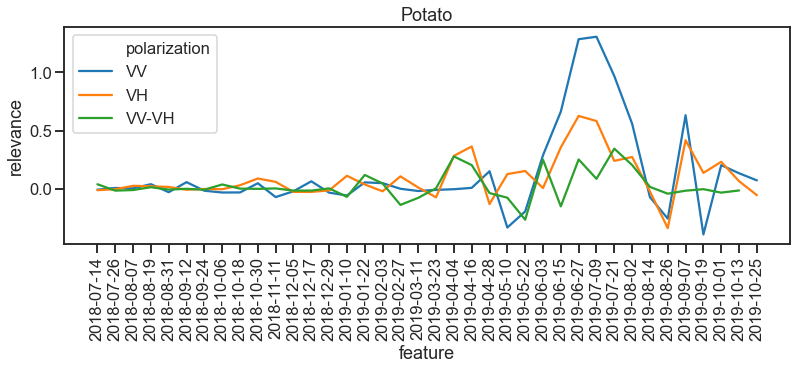

time: 1.2 s


In [72]:
mlp_explanation("Potato")

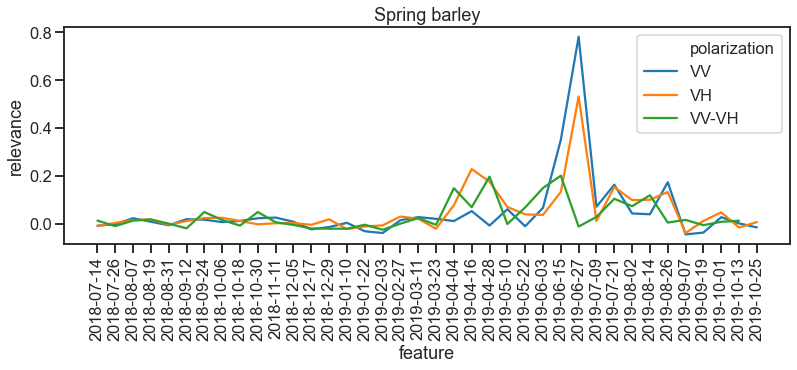

time: 990 ms


In [80]:
mlp_explanation("Spring barley")

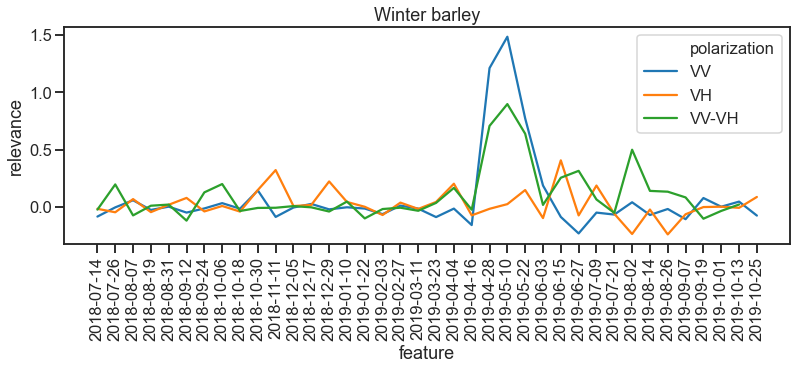

time: 965 ms


In [76]:
mlp_explanation("Winter barley")

       feature    weight polarization
38  2018-07-14  0.002792           VH
0   2018-07-14  0.004626           VV
76  2018-07-14 -0.010430        VV-VH
39  2018-07-26  0.007421           VH
1   2018-07-26 -0.006893           VV


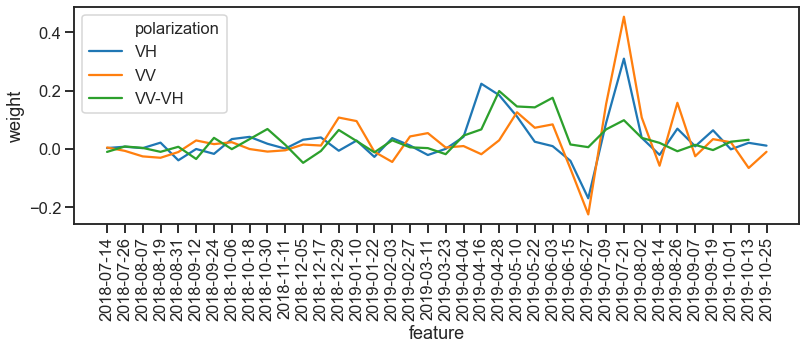

time: 1.56 s


In [27]:
mlp_explanation("Spring wheat")

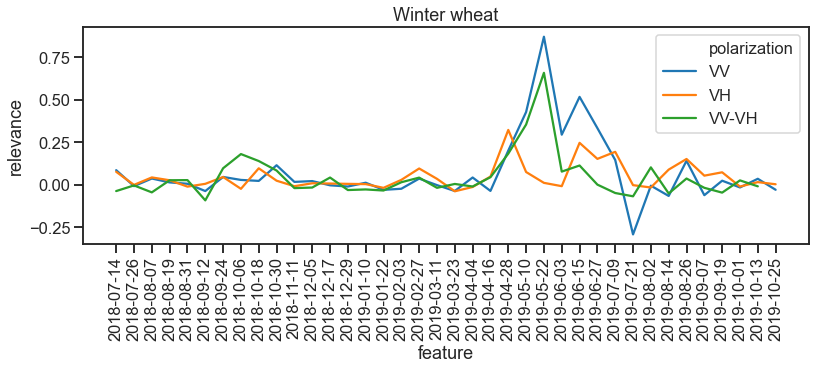

time: 1 s


In [75]:
mlp_explanation("Winter wheat")

       feature    weight polarization
38  2018-07-14 -0.016854           VH
0   2018-07-14 -0.010999           VV
76  2018-07-14  0.003479        VV-VH
39  2018-07-26  0.024701           VH
1   2018-07-26  0.021528           VV


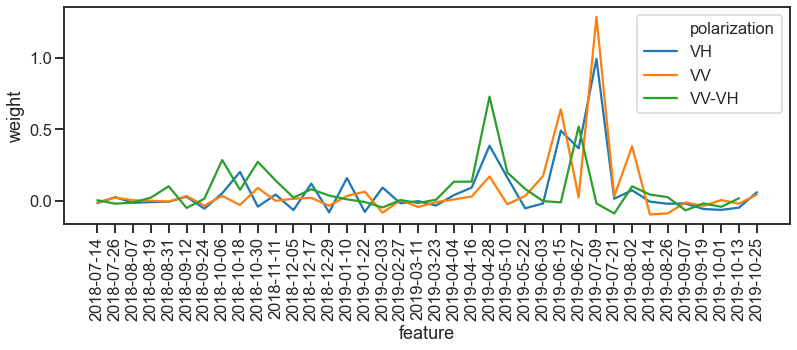

time: 1.25 s


In [29]:
mlp_explanation("Winter rye")

       feature    weight polarization
38  2018-07-14 -0.011176           VH
0   2018-07-14 -0.011761           VV
76  2018-07-14 -0.003459        VV-VH
39  2018-07-26 -0.010882           VH
1   2018-07-26  0.002287           VV


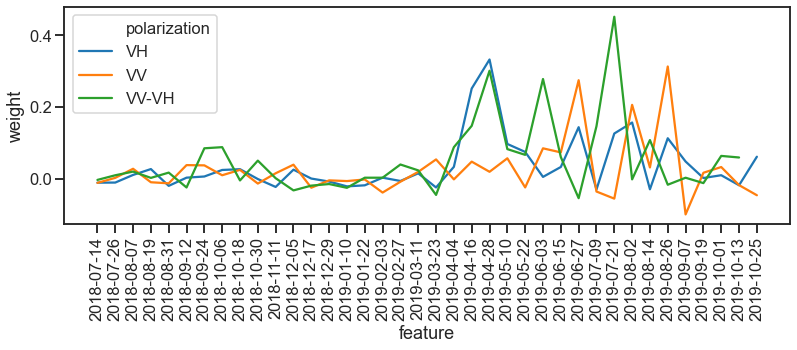

time: 963 ms


In [30]:
mlp_explanation("Spring oat")

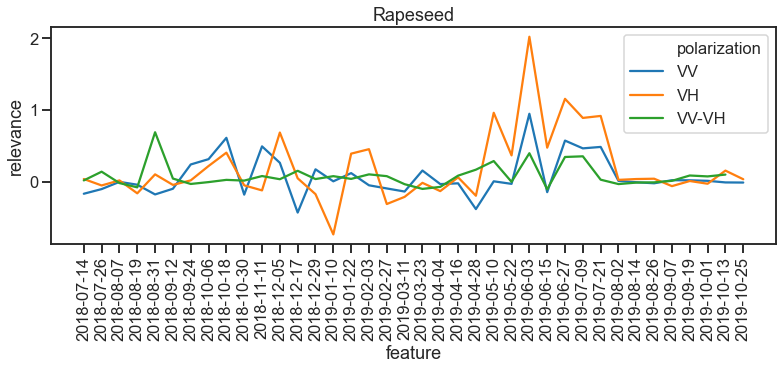

time: 1.03 s


In [81]:
mlp_explanation("Rapeseed")

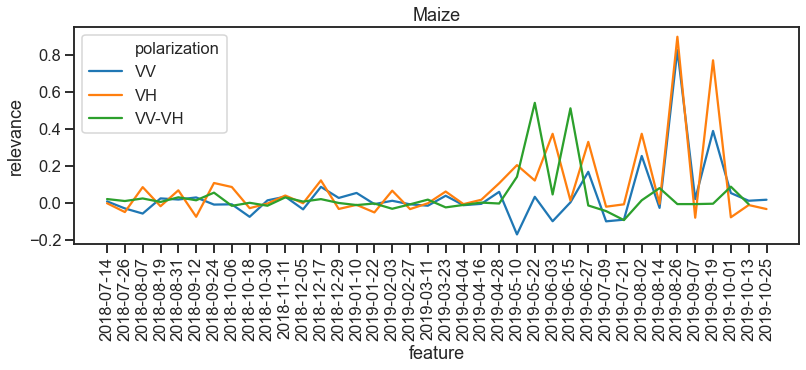

time: 1.04 s


In [82]:
mlp_explanation("Maize")

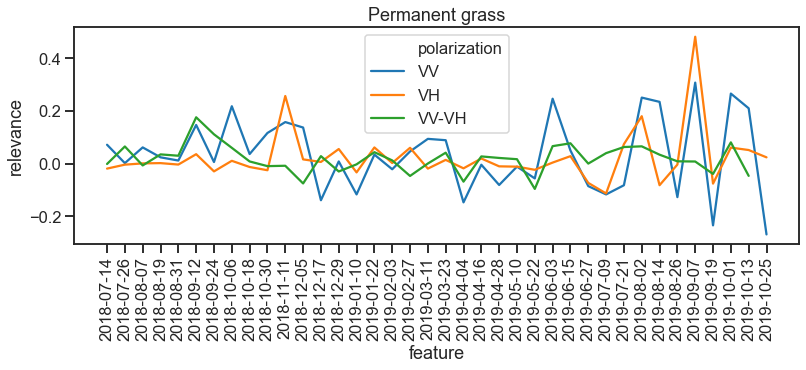

time: 1.1 s


In [83]:
mlp_explanation("Permanent grass")

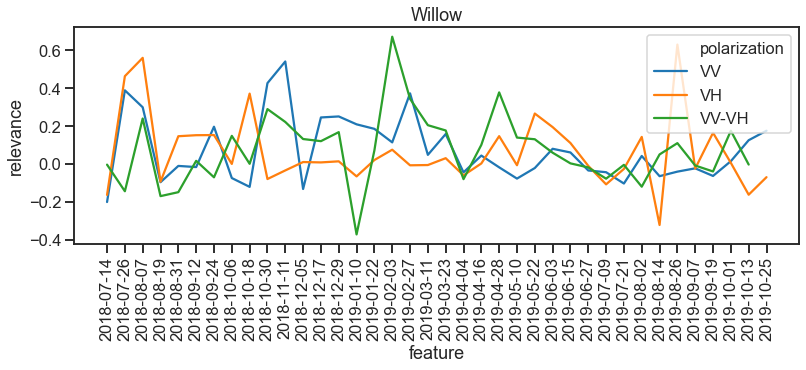

time: 1.32 s


In [84]:
mlp_explanation("Willow")

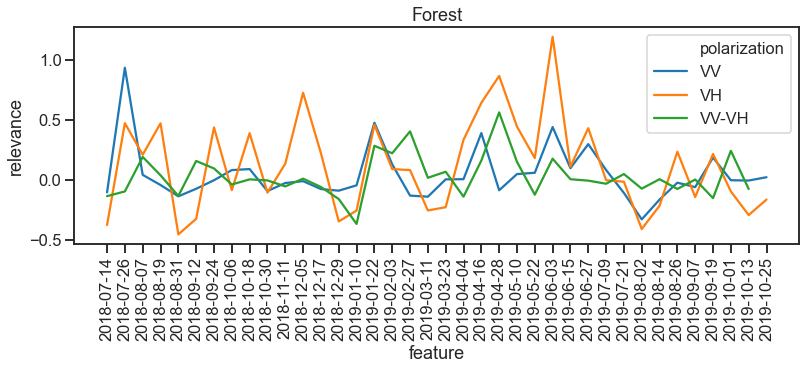

time: 1.45 s


In [85]:
mlp_explanation("Forest")

# LRP-Alpha1Beta0

In [ ]:
empty_array_ab = np.empty((0, 114), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp", model_wo_sm, rule = ["Z", "Z"], input_layer_rule = "Alpha1Beta0")
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,114))
    empty_array_ab = np.append(empty_array_ab, analysis, axis=0)

In [ ]:
mlp_explanation("Potato", empty_array_ab)

In [ ]:
mlp_explanation("Spring wheat", empty_array_ab)

In [ ]:
mlp_explanation("Winter wheat", empty_array_ab)

In [ ]:
mlp_explanation("Rapeseed", empty_array_ab)

In [ ]:
mlp_explanation("Forest", empty_array_ab)

# LRP-Alpha2Beta1

In [ ]:
empty_array_a2b1 = np.empty((0, 114), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp", model_wo_sm, rule = ["Z", "Z"], input_layer_rule = "Alpha2Beta1")
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,114))
    empty_array_a2b1 = np.append(empty_array_a2b1, analysis, axis=0)

In [ ]:
mlp_explanation("Potato", empty_array_a2b1)

In [ ]:
mlp_explanation("Spring wheat", empty_array_a2b1)

In [ ]:
mlp_explanation("Winter wheat", empty_array_a2b1)

In [ ]:
mlp_explanation("Rapeseed", empty_array_a2b1)